In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
import json
from tensorflow.python.ops import parallel_for as pfor
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import nn_ops

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import numpy as np
from scipy import linalg as LA
import json
from collections import defaultdict

In [2]:
import sys
import getpass

ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
    
net = 'highd_inputs'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net)

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from tools_lnd import name_best_ckpt, gen_X_from_model_dir
import tools
from network import Model, get_perf
from train import do_eval, do_eval_test

In [3]:
def popvec(y):
    """Population vector read out.

    Assuming the last dimension is the dimension to be collapsed

    Args:
        y: population output on a ring network. Numpy array (Batch, Units)

    Returns:
        Readout locations: Numpy array (Batch,)
    """
    pref = np.arange(0, 2*np.pi, 2*np.pi/y.shape[-1])  # preferences
    temp_sum = y.sum(axis=-1)
    temp_cos = np.sum(y*np.cos(pref), axis=-1)/temp_sum
    temp_sin = np.sum(y*np.sin(pref), axis=-1)/temp_sum
    loc = np.arctan2(temp_sin, temp_cos)
    return np.mod(loc, 2*np.pi)

def calc_lsq(model_dir,rule):
    model = Model(model_dir)
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        c_lsq, c_reg, perf_test = do_eval_test(sess, model, rule)
    return c_lsq, c_reg, perf_test

In [4]:
def plot_train_progress(model_path,n_models,task_set,cmap):
    fig = plt.figure(figsize=(10, 5))
    for n in range(n_models):
        model_dir = os.path.join(p,model_path,str(n))

        fname = os.path.join(model_dir, 'log.json')
        with open(fname, 'r') as f:
            log_all = json.load(f)

        for r in task_set:
            c = cmap(r/20)
            
            ax = fig.add_subplot(121)
            x = np.log(log_all['cost_'+rules_dict['all'][r]])
            N = 30
            plt.plot(np.convolve(x, np.ones((N,))/N, mode='valid'),'-',c = c)
#             plt.plot(np.log(log_all['cost_'+rules_dict['all'][r]]),'-',c = c)
            ax.set_title('Cost')
            ax.set_xlabel('Training Step (x 1000)')

            ax = fig.add_subplot(122)
            x = log_all['perf_'+rules_dict['all'][r]]
            N = 30
            plt.plot(np.convolve(x, np.ones((N,))/N, mode='valid'),'-',c = c)
            ax.set_title('Performance')
            ax.set_xlabel('Training Step (x 1000)')

In [5]:
n = 0
rule = 'delaygo'
model_path = os.path.join(p,'data/rnn/multitask/crystals/softplus/l2w001')
model_dir = os.path.join(model_path,str(n))

model = Model(model_dir)
with tf.Session() as sess:
    model.restore()
    # model._sigma=0
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
#         params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    # create a trial
    trial = generate_trials(rule, hparams, mode='random', noise_on=True, batch_size =100, delay_fac =1)
    
ckpt_n = name_best_ckpt(model_dir,rule)
ckpt_n_dir = os.path.join(model_dir,'ckpts/model.ckpt-' + str(int(ckpt_n)))
X,x = gen_X_from_model_dir(model_dir,ckpt_n_dir,trial)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w001/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documen

In [6]:
#ALL TASK MODELS
cmap=plt.get_cmap('Greys')
# model_path = os.path.join(p,'/Users/lauradriscoll/Documents/data/rnn/multitask/lowD/grad_norm_l2001/most')
# model_path = os.path.join(p,'/Users/lauradriscoll/Documents/data/rnn/multitask/train_all_1')
# model_path = os.path.join(p,'/Users/lauradriscoll/Documents/data/rnn/multitask/lowD/grad_norm_l2h000001/most')
# model_path = os.path.join(p,'/Users/lauradriscoll/Documents/data/rnn/multitask/lowD/armnet_noreg/most')
# model_path = os.path.join(p,'/Users/lauradriscoll/Documents/data/rnn/multitask/lowD/combos/most')
# model_path = 'data/rnn/multitask/crystals/softplus/l2h00001'
# model_path = os.path.join(p,'data/rnn/multitask/crystals/softplus/l2w0001')
# # model_path = os.path.join(p,'data/rnn/multitask/crystals/softplus/no_reg')
# model_path = os.path.join(p,'data/rnn/multitask/crystals/softplus/')
# model_path = os.path.join(p,'data/rnn/multitask/lowD/')
# ,dir_set[n]
# dir_set = ['no_reg','l2h000001','l2w0001']
# dir_set = ['combos/most','grad_norm_l2h000001/most','grad_norm_l2001/most']
dir_set = ['crystals/softplus/l2h00001','crystals/softplus/l2h00001','crystals/relu/l2w0001']
# dir_set = ['lowD/combos/most','lowD/grad_norm_l2h000001/most','lowD/grad_norm_l2001/most'] 

model_path = os.path.join(p,'data/rnn/multitask/','crystals','softplus','both')
model_n = 2
task_set = [0,1,2,3,4,5,11,12,13,14,15,16,17,18,19]
task_set = [8,9]

fig = plt.figure(figsize=(15, 5))
for n in range(np.shape(dir_set)[0]):
    model_dir = os.path.join(p,'data/rnn/multitask/',dir_set[n],str(model_n))
    model_dir = '/home/laura/code/multitask-nets/highd_inputs/data/crystals/highd_inputs/contextdm1_contextdm2_8/softplus/no_reg_pref_tuned/0/'

    fname = os.path.join(model_dir, 'log.json')
    with open(fname, 'r') as f:
        log_all = json.load(f)

    for r in task_set:
        c = cmap(r/20)

        ax = fig.add_subplot(1,np.shape(dir_set)[0],n+1)
        x = np.log(log_all['cost_'+rules_dict['all'][r]])
        plt.plot(x,'-',c = c)
        ax.set_title(dir_set[n])
        ax.set_xlabel('Training Step (x 1000)')
        plt.ylim([-6,2])

#         plt.xlim([1000,1500])

#         ax = fig.add_subplot(122)
#         x = log_all['perf_'+rules_dict['all'][r]]
#         plt.plot(x,'-',c = c)
#         ax.set_title('Performance')
#         ax.set_xlabel('Training Step (x 1000)')
        
plt.show()
        

IOError: [Errno 2] No such file or directory: '/home/laura/code/multitask-nets/highd_inputs/data/crystals/highd_inputs/contextdm1_contextdm2_8/softplus/no_reg_pref_tuned/0/log.json'

<Figure size 1080x360 with 0 Axes>

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/grad_norm_l2001/most/1/ckpts/model.ckpt-95000


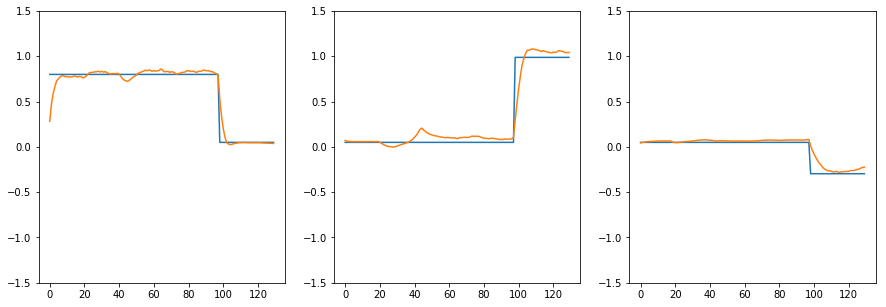

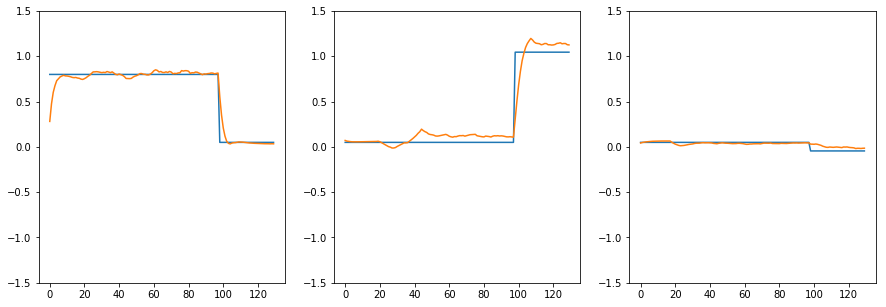

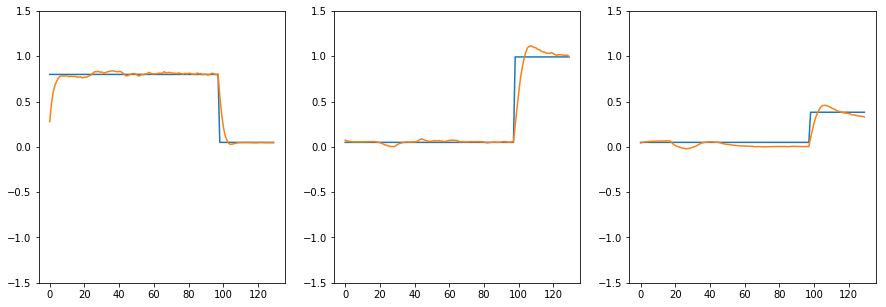

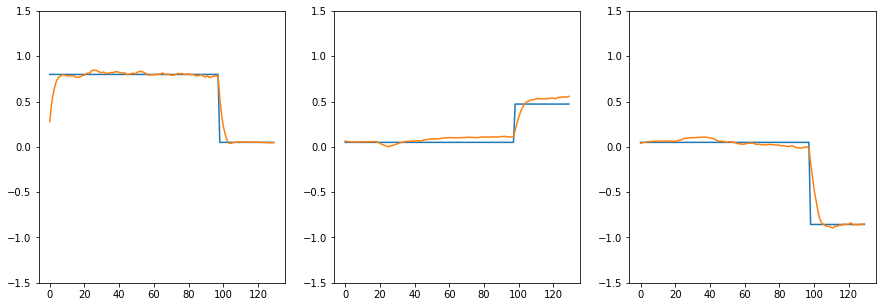

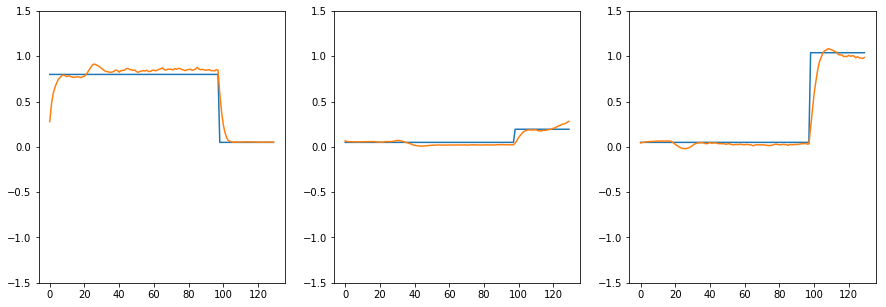

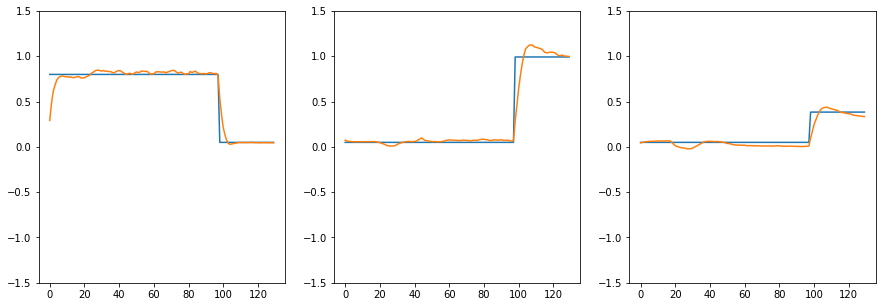

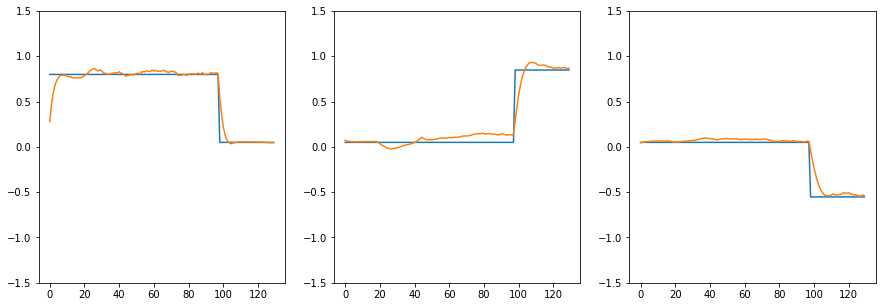

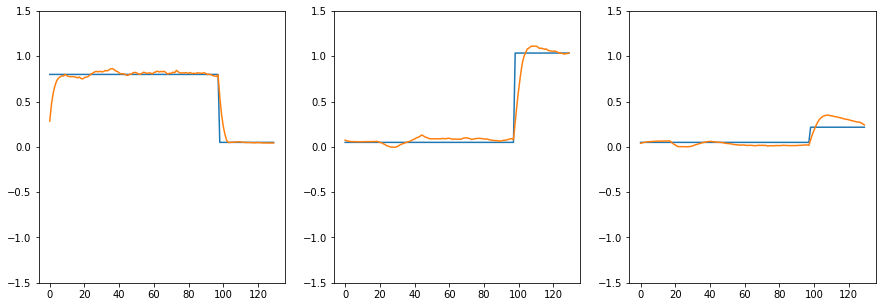

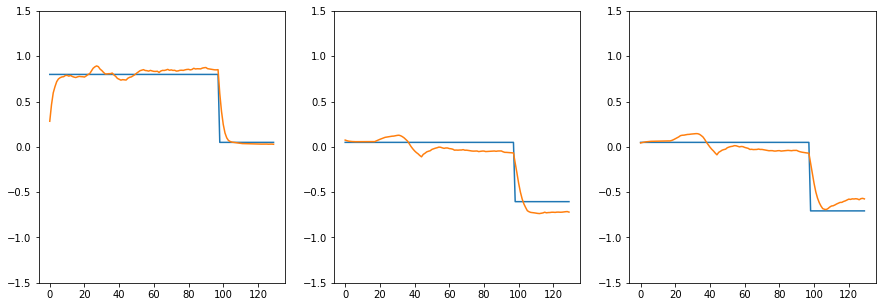

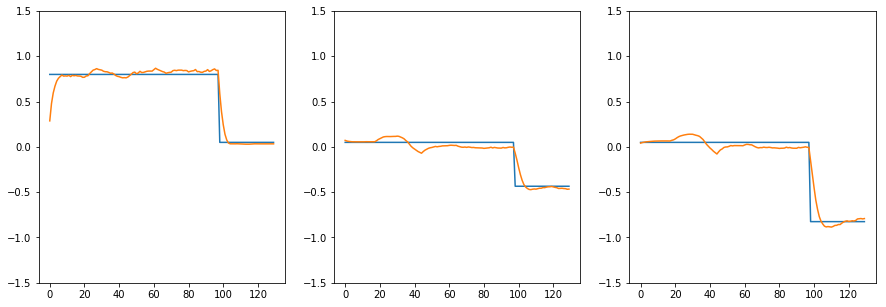

In [13]:

# model_path = os.path.join(p,'data/rnn/multitask/crystals/softplus/l2h00001/')
# model_path = os.path.join(p,'data/rnn/multitask/crystals/softplus/l2w001/')
# model_path = os.path.join(p,'data/rnn/multitask/crystals/softplus/most/')
# model_dir = os.path.join(model_path,str(n))
ckpt_n = name_best_ckpt(model_dir,rule)
# ckpt_n = 280000
ckpt_n_dir = os.path.join(model_dir,'ckpts/model.ckpt-' + str(int(ckpt_n)))

model = Model(model_dir)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    model._sigma=0
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=True, batch_size =100, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    # run model
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) 
    
for y in range(10):
    fig = plt.figure(figsize=(15, 5))
    for x in range(1,4):
        ax = fig.add_subplot(1,3,x)
        plt.plot(trial.y[:,y,x-1])
        plt.plot(y_hat_tf[:,y,x-1])
        plt.ylim([-1.5,1.5])

    plt.show()

In [32]:
print(hparams)

{u'tau': 100, u'l2_weight_init': 0, u'w_rec_init': u'randortho', u'alpha': 0.2, u'target_cost': 0, u'l2_h': 1e-06, u'n_output': 3, u'rule_start': 5, u'sigma_x': 0.1, u'batch_size_train': 64, u'target_perf': 1.0, u'l1_h': 0, u'n_rnn': 256, u'rules': [u'fdgo', u'reactgo', u'delaygo', u'fdanti', u'reactanti', u'delayanti', u'delaydm1', u'delaydm2', u'contextdelaydm1', u'contextdelaydm2', u'multidelaydm', u'dmsgo', u'dmsnogo', u'dmcgo', u'dmcnogo'], u'n_eachring': 2, u'p_weight_train': None, u'learning_rate': 0.001, u'save_name': u'test', u'ruleset': u'all', u'loss_type': u'lsq', u'optimizer': u'adam', u'rule_probs': [0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667], u'n_input': 25, u'l1_weight': 0, u'activation': u'softplus', '

In [ ]:
#Big Validation
cmap=plt.get_cmap('Purples')
model_path = '/home/laura/code/yangnet/training/data/big_validation/fdgo/'
model_path = '/home/laura/code/yangnet/training/data/big_validation/reactgo/'
model_path = '/home/laura/code/yangnet/training/data/big_validation/all/'
model_path = '/home/laura/code/multitask-nets/stepnet/data/lowDin/softplus/most/'
n_models = 1
task_set = range(11,13)#range(20) # change
# plot_train_progress(model_path,n_models,task_set,cmap)


fig = plt.figure(figsize=(10, 5))
for n in range(n_models):
    model_dir = os.path.join(model_path,str(n))

    fname = os.path.join(model_dir, 'log.json')
    with open(fname, 'r') as f:
        log_all = json.load(f)

    for r in task_set:
        c = cmap(r/20)#c = 'k'

        ax = fig.add_subplot(121)
        x = np.log(log_all['cost_'+rules_dict['all'][r]])
        N = 30
        plt.plot(np.convolve(x, np.ones((N,))/N, mode='valid'),'-',c = c)
        ax.set_title('Cost')
        ax.set_xlabel('Training Step (x 1000)')
#         ax.set_ylim((-10.5,-9))
        

        ax = fig.add_subplot(122)   
        x = log_all['perf_'+rules_dict['all'][r]]
        N = 20
        plt.plot(np.convolve(x, np.ones((N,))/N, mode='valid'),'-',c = c)
        ax.set_title('Performance')
        ax.set_xlabel('Training Step (x 1000)')

In [ ]:
#SINGLE TASK MODELS
cmap=plt.get_cmap('Greens')
dmap=plt.get_cmap('Blues')
model_path = '/home/laura/code/yangnet/data/sub_training/'
delay_tasks = np.array([2,5,11,12,13,14,15,16,17,18,19])
n_models = 5
task_set = range(20)

fig = plt.figure(figsize=(10, 5))
for n in range(n_models):   

    for r in task_set:

        model_dir = os.path.join(model_path,rules_dict['all'][r],str(20+n))

        fname = os.path.join(model_dir, 'log.json')
        with open(fname, 'r') as f:
            log_all = json.load(f)
        
        if r in delay_tasks:
            c = dmap(r/20)
        else:
            c = cmap(r/20)

        ax = fig.add_subplot(121)
        plt.plot(np.log(log_all['cost_'+rules_dict['all'][r]]),':',c = c)

        ax = fig.add_subplot(122)
        plt.plot(log_all['perf_'+rules_dict['all'][r]],':',c = c)

In [ ]:
# SUBSET OF DELAY TASK MODELS
delay_tasks = np.array([2,5,11,12,13,14,15,16,17,18,19])
cmap=plt.get_cmap('Blues')
n_models = 3
task_set = range(len(delay_tasks))
ntasks = len(delay_tasks)

for task_n in range(ntasks):
    model_path = os.path.join('/home/laura/code/yangnet/training/data/n8_ntasks',str(task_n))
    plot_train_progress(model_path,n_models,delay_tasks[0:task_n],cmap)

In [ ]:
# DELAY FACTOR ADJUSTMENT MODELS
cmap=plt.get_cmap('Reds')
ntasks = 11
fig = plt.figure(figsize=(10, 5))
for delay_fac in [.25]: #, .5, .75, 2, 3
    for n in range(2):
        model_dir = os.path.join('/home/laura/code/yangnet/training/data/n8_delay_fac','delay_fac_'+str(100*delay_fac),str(n))

        fname = os.path.join(model_dir, 'log.json')
        with open(fname, 'r') as f:
            log_all = json.load(f)

        for r in delay_tasks[0:task_n]:
            
            c = cmap(r/20)
                
            ax = fig.add_subplot(121)
            plt.plot(log_all['cost_'+rules_dict['all'][r]],c = c)
            ax.set_ylim(0, .2)
            ax = fig.add_subplot(122)
            plt.plot(log_all['perf_'+rules_dict['all'][r]],c = c)
        
print(log_all.keys())

In [ ]:
#Run manual RNN to find hiddens and outputs
sigma_rec = hp['sigma_rec']
dt = hp['dt']
tau = hp['tau']
alpha = dt/tau
step = 135 #training step

w_in = log_all['w_in'][step]
b_in = log_all['b_in'][step]
w_out = log_all['w_out'][step]
b_out = log_all['b_out'][step]
print(np.shape(w_in))

h = tf.expand_dims(h_tf[0,:,:],axis=0)

for t in range(np.shape(trial.x)[0]-1):
    state = h[t,:,:]
    inputs = trial.x[t+1,:,:]
    
    gate_inputs = math_ops.matmul(array_ops.concat([inputs, state], 1), w_in)
    gate_inputs = nn_ops.bias_add(gate_inputs, b_in)
    noise = tf.random_normal(tf.shape(state), mean=0, stddev=np.sqrt(2*alpha) * sigma_rec)
    #gate_inputs = gate_inputs+noise
    output = tf.nn.softplus(gate_inputs)
    output = (1-alpha) * state + alpha * output
    h = tf.concat([h,tf.expand_dims(output,axis=0)],0)

In [ ]:
i_trial = 0
    
# Calculating output works when you input the correct hidden values  (h_tf)
y_hat_ = tf.matmul(h[:,i_trial,:], w_out) + b_out
y_hat = tf.sigmoid(y_hat_)

In [ ]:
print(log_all.keys())

In [ ]:
print('step # '+ str(step))
for activity, title in zip([trial.x[:,i_trial,:], h[:,i_trial,:], y_hat],['input', 'recurrent', 'output']):
    plt.figure()
    my_img = tf.transpose(activity)
    
    with tf.Session() as sess:
        image = my_img.eval()
        
    plt.imshow(image, aspect='auto', cmap='hot',
           interpolation='none', origin='lower')
    plt.title(title)
    plt.colorbar()
    plt.show()

In [ ]:
print('step # '+ str(step))
for activity, title in zip([trial.x[:,i_trial,:], h[:,i_trial,:], y_hat],['input', 'recurrent', 'output']):
    plt.figure()
    my_img = tf.transpose(activity)
    
    with tf.Session() as sess:
        image = my_img.eval()
        
    plt.imshow(image, aspect='auto', cmap='hot',
           interpolation='none', origin='lower')
    plt.title(title)
    plt.colorbar()
    plt.show()
    

In [ ]:
print('step # '+ str(step))
for activity, title in zip([trial.x[:,i_trial,:], h[:,i_trial,:], y_hat],['input', 'recurrent', 'output']):
    plt.figure()
    my_img = tf.transpose(activity)
    
    with tf.Session() as sess:
        image = my_img.eval()
        
    plt.imshow(image, aspect='auto', cmap='hot',
           interpolation='none', origin='lower')
    plt.title(title)
    plt.colorbar()
    plt.show()
    

In [ ]:
for activity, title in zip([trial.x[:,i_trial,:], h_tf[:,i_trial,:], y_hat_tf[:,i_trial,:]],['input', 'recurrent', 'output']):
    plt.figure()
    my_img = tf.transpose(activity)
    
    with tf.Session() as sess:
        image = my_img.eval()
        
    plt.imshow(image, aspect='auto', cmap='hot',
           interpolation='none', origin='lower')
    plt.title(title)
    plt.colorbar()
    plt.show()

In [ ]:
n_rules = 3
n_models = 20
c_lsq_sing = np.zeros((n_rules,n_models))
c_lsq_all = np.zeros((n_rules,n_models))

for rule_n in range(n_rules):   
    rule_train = rules_dict['all'][rule_n]
    rule_test = rules_dict['all'][rule_n+3]

    for model_n in range(n_models):        

        model_path_single = os.path.join(p,'/code/yangnet/data/sub_training/',rule_train,str(20+model_n))
        c_lsq_sing[rule_n,model_n], _, _ = calc_lsq(model_path_single,rule_test)

        model_path_all = os.path.join('/home/laura/data/multitask/train_all',str(model_n))
        c_lsq_all[rule_n,model_n], _, _ = calc_lsq(model_path_all,rule_test)
        
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

for rule_n in range(n_rules):
    plt.plot(rule_n*np.ones(n_models),c_lsq_sing[rule_n,:],'.g')
    plt.plot(rule_n*np.ones(n_models)-.1,c_lsq_all[rule_n,:],'.k')
    
ax.set_xlabel('Task', fontweight='bold')
ax.set_ylabel('Validation Error', fontweight='bold')
fig.legend(('Single Task Networks','Multiple Task Networks'))
plt.xticks(np.arange(n_rules),(rules_dict['all'][:]))

In [ ]:
rule_train = 'fdgo'
rule_test = 'fdanti'
model_n = 0
model_dir = os.path.join('/home/laura/code/yangnet/data/sub_training/',rule_train,str(20+model_n))

model = Model(model_dir)
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    hp = model.hp

    trial = generate_trials(rule_test, hp, 'test')
    feed_dict = tools.gen_feed_dict(model, trial, hp)
    c_lsq, c_reg, y_hat_test = sess.run(
        [model.cost_lsq, model.cost_reg, model.y_hat],feed_dict=feed_dict)

    # Cost is first summed over time,
    # and averaged across batch and units
    # We did the averaging over time through c_mask
    perf_test = np.mean(get_perf(y_hat_test, trial.y_loc))

In [ ]:
# rule = 'fdgo'
# model_n = 3
# model_dir = os.path.join('/home/laura/code/yangnet/training/data/n8_uniform_stim/','all',str(model_n))

model_n = 2
n_tasks = 1
rule = 'delaygo'
# model_dir = os.path.join('/home/laura/data/multitask/train_all',str(model_n))
# model_dir = os.path.join('/home/laura/code/yangnet/training/data/n8_ntasks',str(n_tasks-1),str(model_n))
model_dir = os.path.join('/home/laura/code/yangnet/data/sub_training/',rule,str(21))

fname = os.path.join(model_dir, 'log.json')
with open(fname, 'r') as f:
    log_all = json.load(f)
    
model = Model(model_dir)
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    hp = model.hp
    trial = generate_trials(rule, hp, mode='test', noise_on=False, batch_size =1, delay_fac =1)
    # get feed_dict
    feed_dict = tools.gen_feed_dict(model, trial, hp)
    # run model
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)